In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import bayesflow as bf
import numpy as np
from src.AmortizedMixture import *
from src.models.NormalMixture import *

/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
model = NormalMixture(n_cls=2, n_obs=[30, 220], n_rep=[1,10], separation=3.0)

In [3]:
local_summary_net = bf.networks.DeepSet(summary_dim=1)
global_summary_net = bf.networks.SetTransformer(input_dim=1, summary_dim=model.n_par*2)
trainer = bf.trainers.Trainer(
    amortizer=AmortizedMixturePosterior(
        amortized_mixture=AmortizedMixture(
            inference_net=IndependentClassificator(num_outputs=model.n_cls, num_dense=8),
            local_summary_net=local_summary_net
        ),
        amortized_posterior=bf.amortizers.AmortizedPosterior(
            inference_net=bf.networks.InvertibleNetwork(num_params=model.n_par, num_coupling_layers=10, coupling_design="spline"), 
            summary_net=bf.networks.HierarchicalNetwork([local_summary_net, global_summary_net]),
            summary_loss_fun="MMD"
        )
    ), 
    generative_model=model, 
    configurator=lambda x: x, 
    checkpoint_path="checkpoints/mixture_posterior")

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [4]:
%%time
h = trainer.train_online(epochs=50, iterations_per_epoch=1000, batch_size=32)

Training epoch 50: 100%|██████████| 1000/1000 [02:22<00:00,  7.04it/s, Epoch: 50, Iter: 1000,Mix.Loss: 2.878,Post.Loss: -0.123,W.Decay: 0.040,Avg.Mix.Loss: 3.873,Avg.Post.Loss: -1.979,Avg.W.Decay: 0.040,LR: 0.00E+00]


CPU times: user 5h 52min 13s, sys: 1h 58min 53s, total: 7h 51min 6s
Wall time: 1h 58min 22s


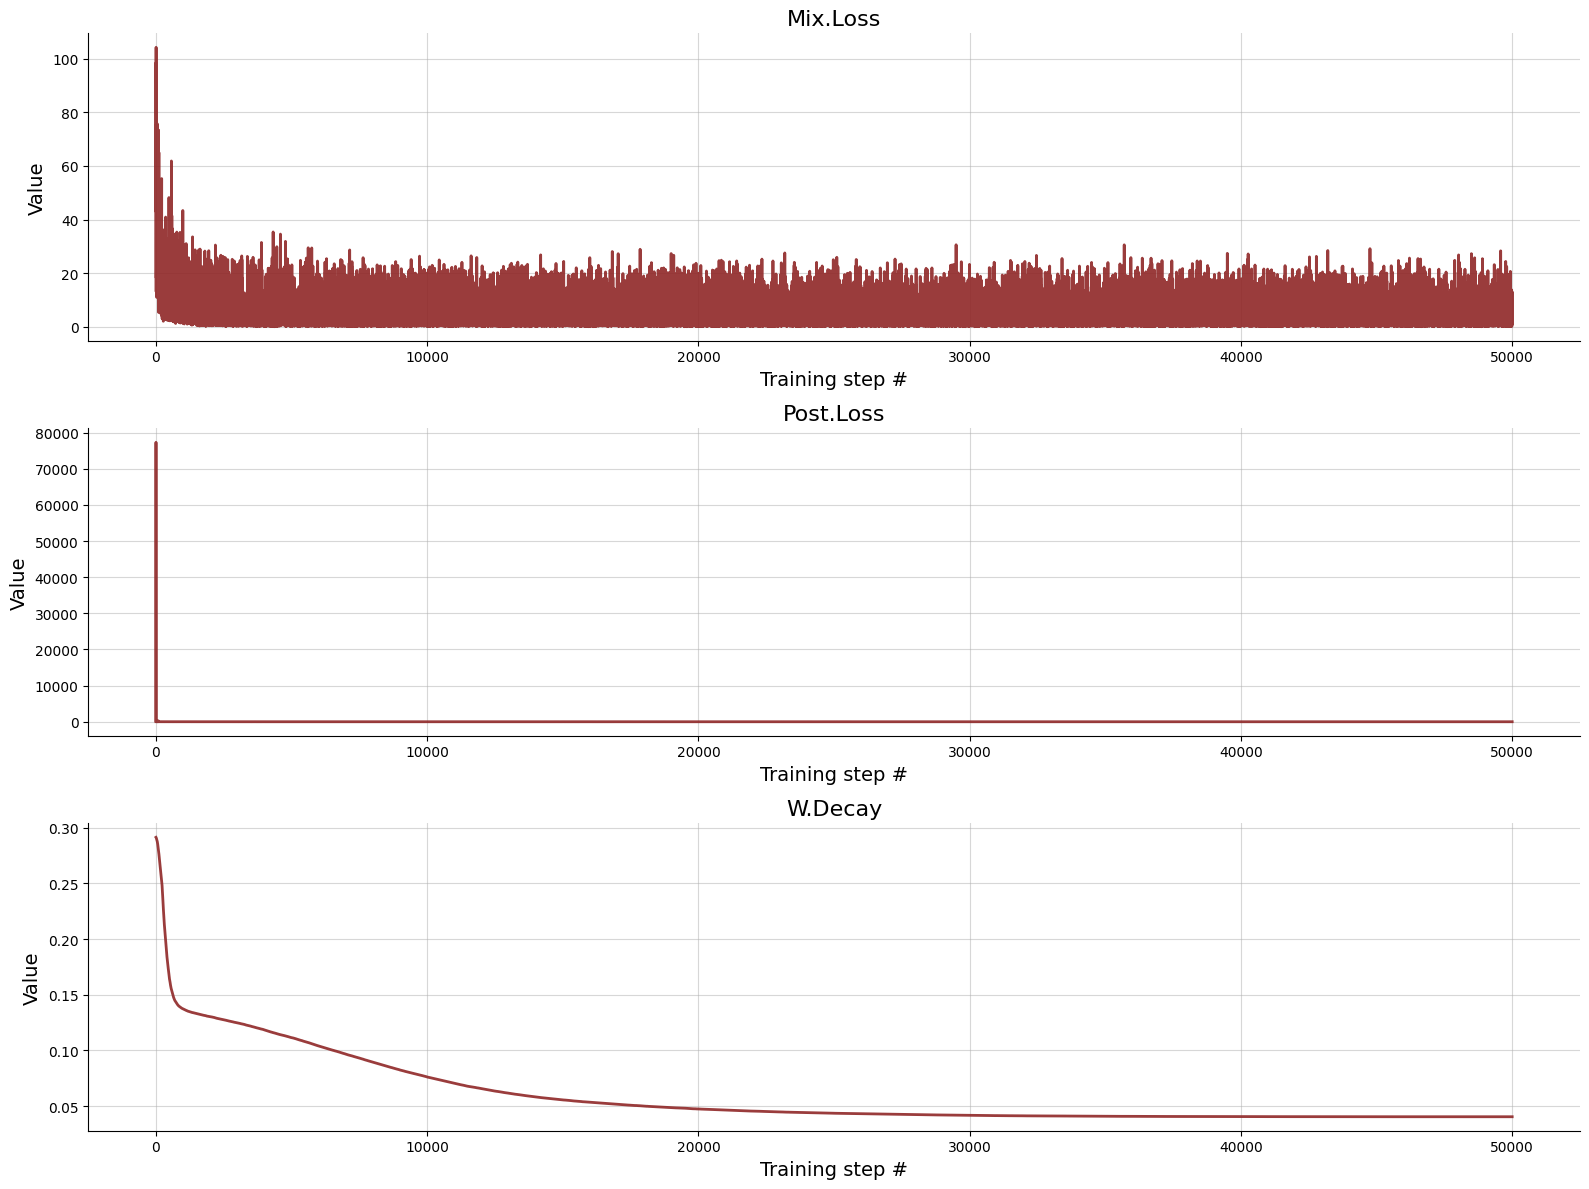

In [5]:
f=bf.diagnostics.plot_losses(h)

## Diagnostics

In [24]:
context = {'n_obs': 100, 'n_rep': 1}
df = model(1000, context=context)

In [25]:
out = trainer.amortizer.sample(df, n_samples=1000)

### Checks on unconstrained parameters

In [26]:
prior_samples = np.array(df['parameters'])
post_samples = out[0]

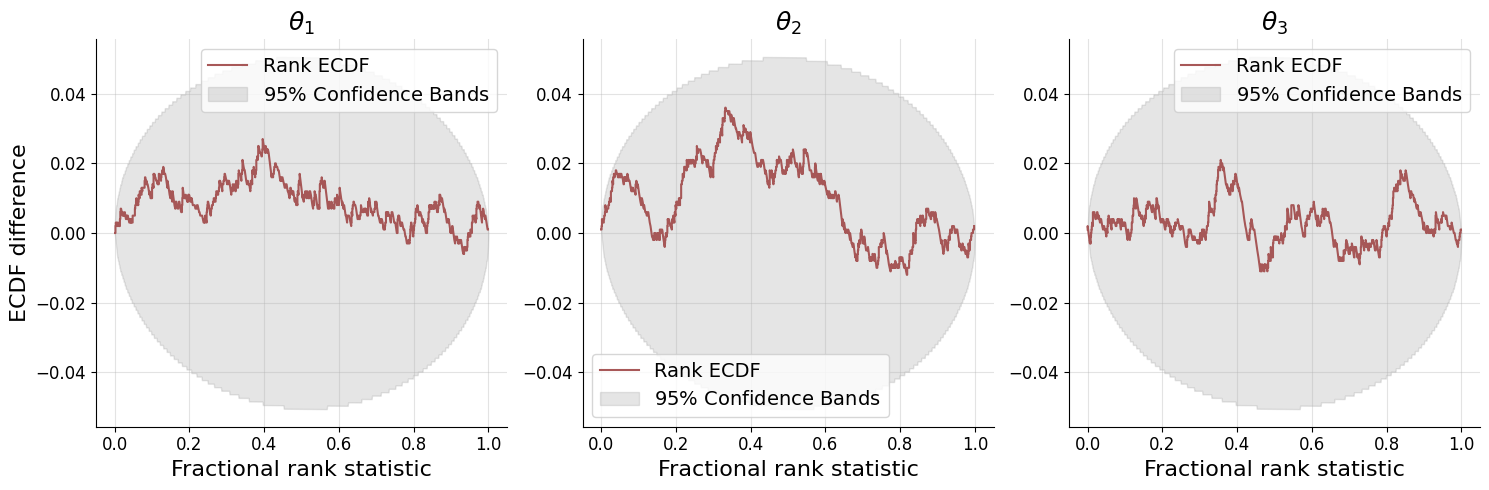

In [27]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples, prior_samples, difference=True)

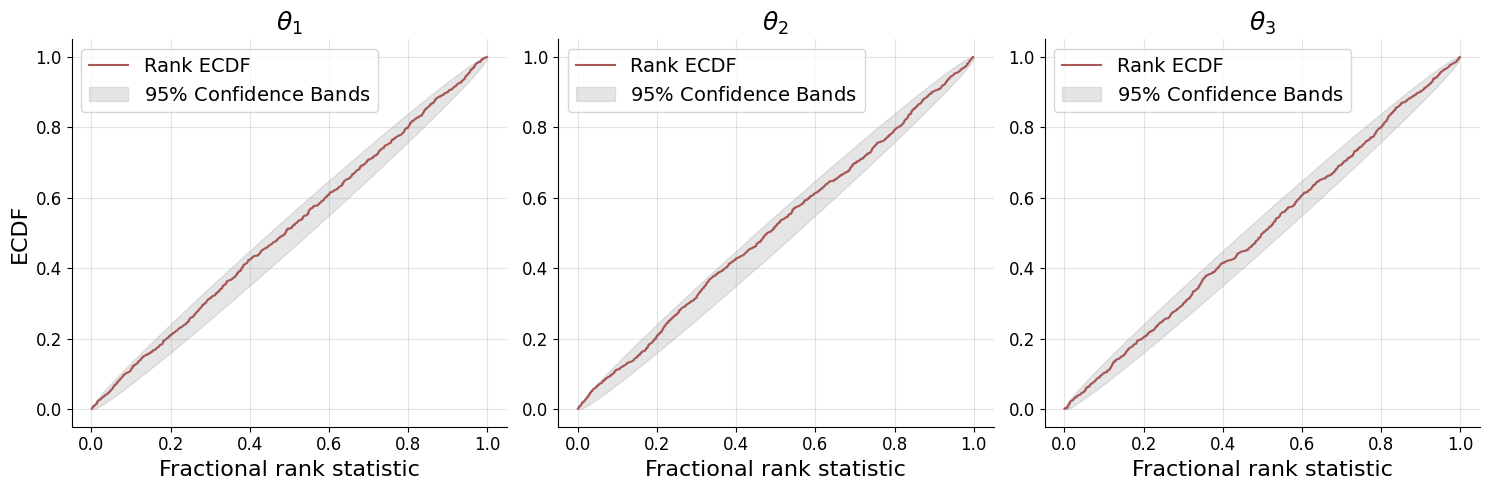

In [28]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples, prior_samples)

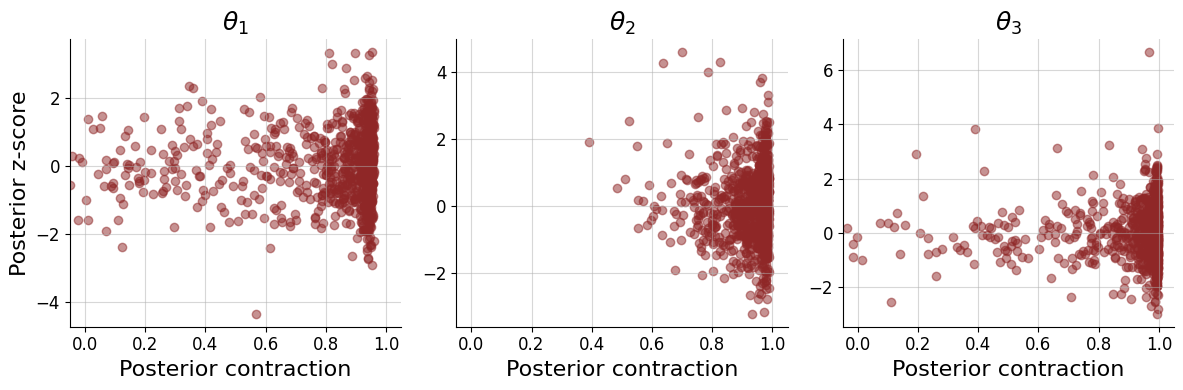

In [29]:
f = bf.diagnostics.plot_z_score_contraction(post_samples, prior_samples)

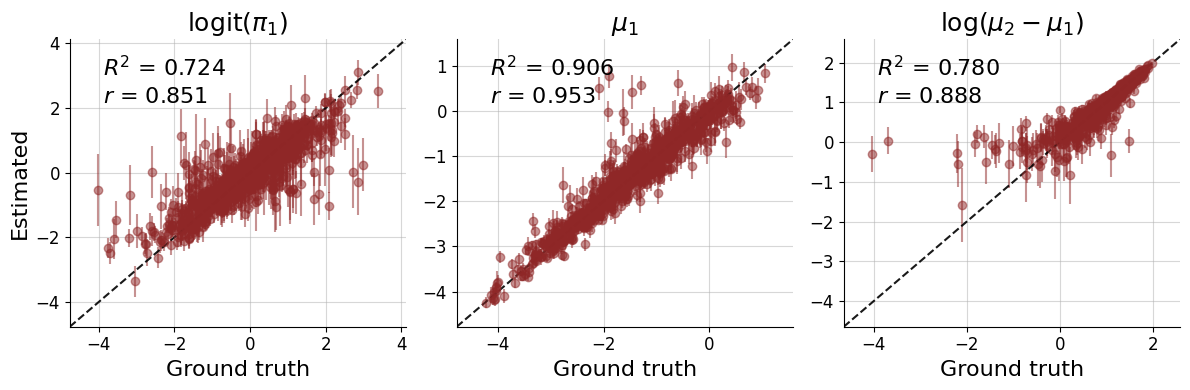

In [30]:
f = bf.diagnostics.plot_recovery(post_samples, prior_samples, param_names=[r"$\text{logit}(\pi_1)$", r"$\mu_1$", r"$\log(\mu_2 - \mu_1)$"])

### Constrained parameters

In [31]:
prior_samples_cons = model.extract_pars(prior_samples, axis=1)
post_samples_cons = model.extract_pars(post_samples, axis=2)

#### Mixture proportions

Since we have only two-component mixture this is a bit redundant since the two constrained parameters are implied completely by one unconstrained parameter (and therefore mirror each other). But, easier to generalize for more components.

In [32]:
param_names = [r'$\pi_1$', r'$\pi_2$']

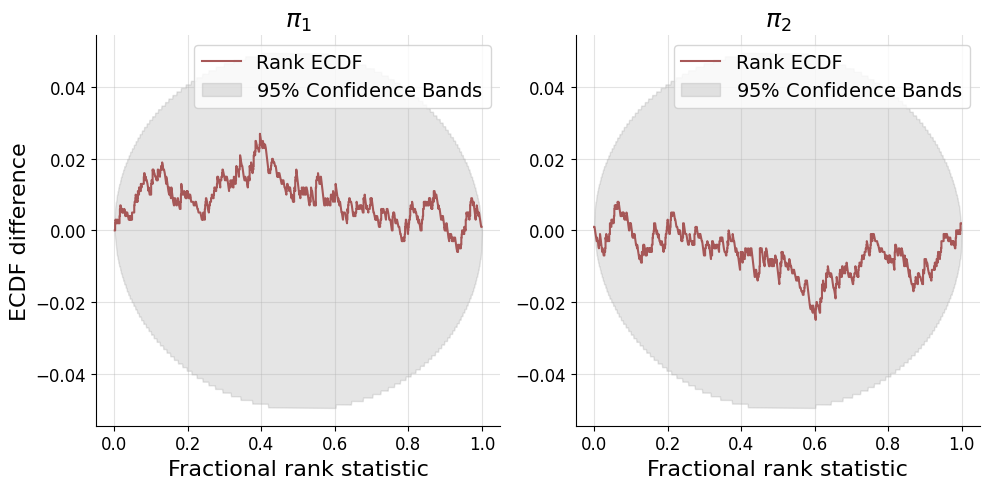

In [33]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples_cons['p'], prior_samples_cons['p'], difference=True, param_names=param_names)

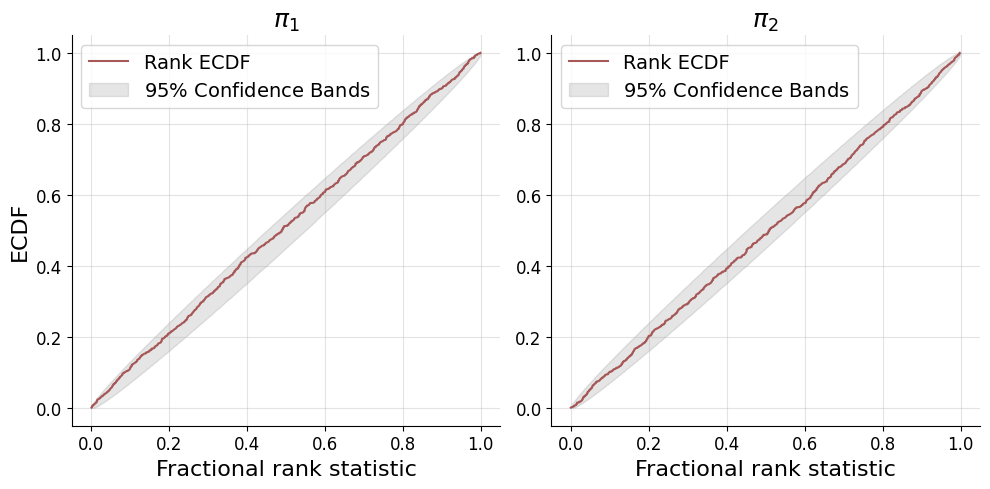

In [34]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples_cons['p'], prior_samples_cons['p'], param_names=param_names)

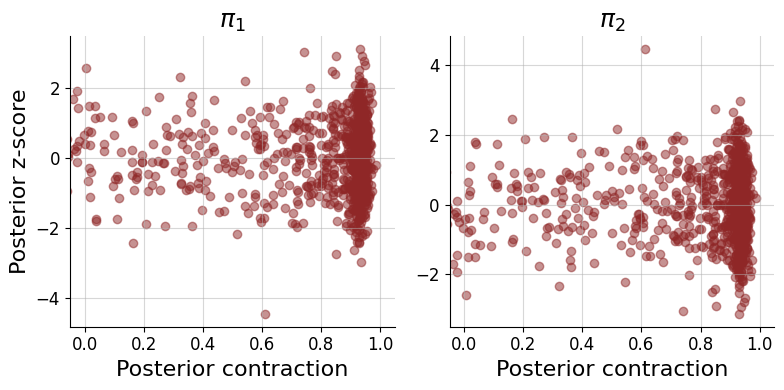

In [35]:
f = bf.diagnostics.plot_z_score_contraction(post_samples_cons['p'], prior_samples_cons['p'], param_names=param_names)

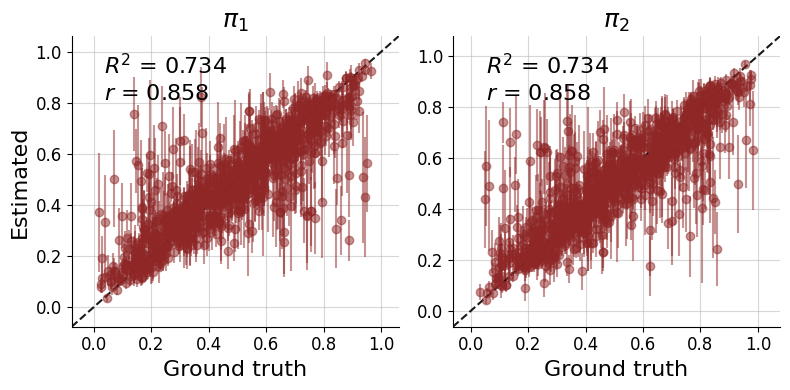

In [36]:
f = bf.diagnostics.plot_recovery(post_samples_cons['p'], prior_samples_cons['p'], param_names=param_names)

#### Mixture means

In [37]:
param_names = [r'$\mu_1$', r'$\mu_2$']

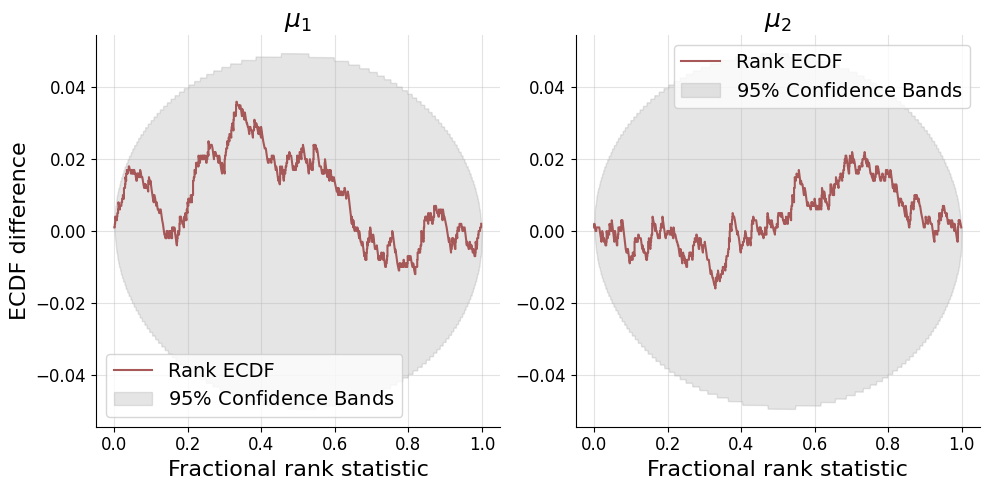

In [38]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples_cons['mu'], prior_samples_cons['mu'], difference=True, param_names=param_names)

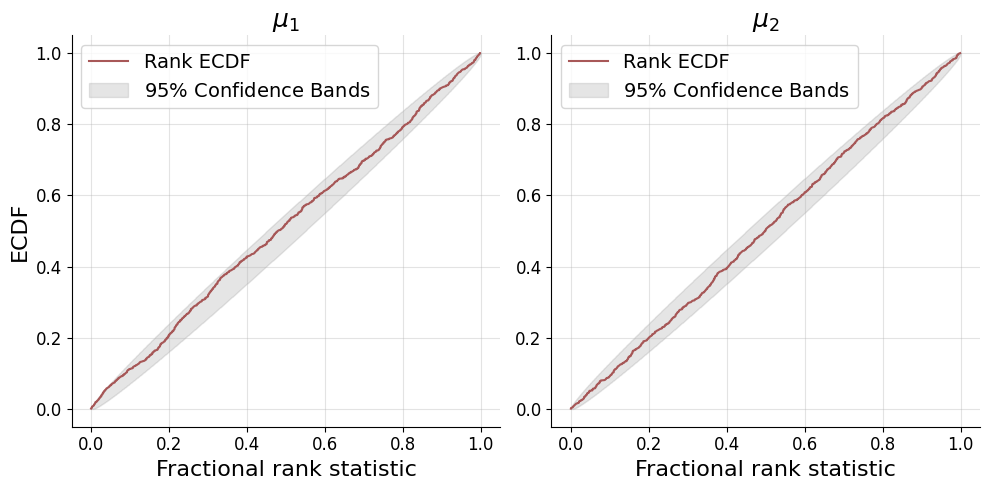

In [39]:
f = bf.diagnostics.plot_sbc_ecdf(post_samples_cons['mu'], prior_samples_cons['mu'], param_names=param_names)

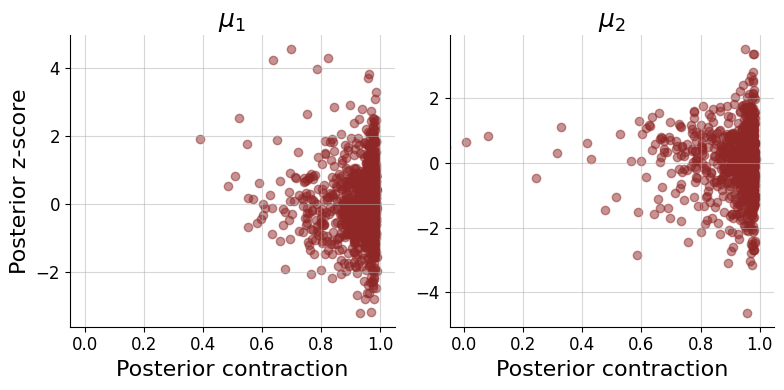

In [40]:
f = bf.diagnostics.plot_z_score_contraction(post_samples_cons['mu'], prior_samples_cons['mu'], param_names=param_names)

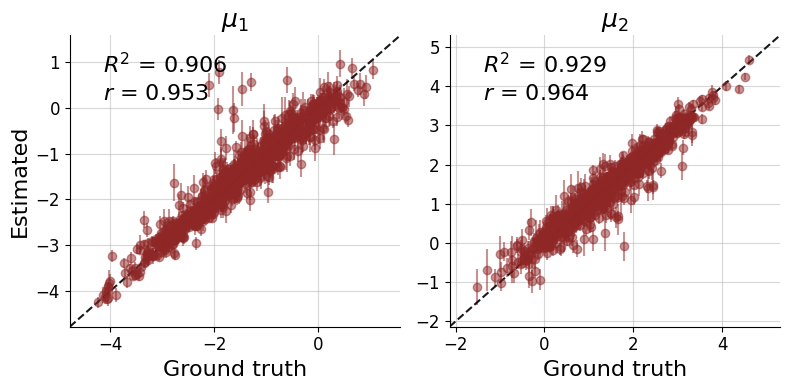

In [41]:
f = bf.diagnostics.plot_recovery(post_samples_cons['mu'], prior_samples_cons['mu'], param_names=param_names)